<a href="https://colab.research.google.com/github/brunacmendes/book-recommender-project/blob/main/DNN_keras_AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [152]:
from __future__ import print_function, division
from builtins import range, input

%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# load in the data
df = pd.read_csv('amazon_ratings.csv')


In [ ]:
df.head()

,user_id,isbn,rating
0,276726,0155061224,5.0
1,276729,052165615X,3.0
2,276729,0521795028,6.0
3,276736,3257224281,8.0
4,276737,0600570967,6.0


Para ter uma ideia melhor de como os dados se parecem, podemos transformá-los em uma tabela selecionando os 15 principais usuários/livros dos dados e juntando-os. O resultado mostra como cada um dos principais usuários classificou cada um dos livros principais.

In [153]:
g = df.groupby('user_id')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]

g = df.groupby('book_id')['rating'].count()
top_books = g.sort_values(ascending=False)[:15]

top_r = df.join(top_users, rsuffix='_r', how='inner', on='user_id')
top_r = top_r.join(top_books, rsuffix='_r', how='inner', on='book_id')

pd.crosstab(top_r.user_id, top_r.book_id, top_r.rating, aggfunc=np.sum)

book_id,0007420412,0007548672,0297859382,0312577222,0316055433,038568231X,0545582881,0553418025,B000X1MX7E
user_id,,,,,,,,,
A13QTZ8CIMHHG4,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
A1D2C0WDCSHUWZ,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
A2F6N60Z96CAJI,NaN,5.0,5.0,4.0,3.0,5.0,4.0,5.0,10.0
A2TX179XAT5GRP,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AHUT55E980RDR,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN


A matriz é bastante esparsa.

Agora preciso transformar os ids dos usuários e dos livros em ids únicos sequenciais começando do zero, para ser usado no modelo.

In [154]:
user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['user_id'].values)
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['book'] = item_enc.fit_transform(df['book_id'].values)
n_books = df['book'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])

n_users, n_books, min_rating, max_rating

(15362618, 2930451, 1.0, 5.0)

In [155]:
df.isnull().sum()

book_id    0
user_id    0
rating     0
user       0
book       0
dtype: int64

In [156]:
# split into train and test

X = df[['user', 'book']].values
y = df['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((46180451, 2), (5131162, 2), (46180451,), (5131162,))

In [157]:
n_factors = 10

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

## Construção do modelo

In [158]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Add, Activation, Lambda
from keras.layers import Concatenate, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam, SGD
from keras.regularizers import l2

In [159]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

In [160]:
def RecommenderNet(n_users, n_books, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    book = Input(shape=(1,))
    m = EmbeddingLayer(n_books, n_factors)(book)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model(inputs=[user, book], outputs=x)
    opt = Adam(lr=0.01)
    #opt=SGD(lr=0.01)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model

In [161]:
model = RecommenderNet(n_users, n_books, n_factors, min_rating, max_rating)
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 1, 10)        153626180   input_38[0][0]                   
__________________________________________________________________________________________________
embedding_39 (Embedding)        (None, 1, 10)        29304510    input_39[0][0]                   
___________________________________________________________________________________________

In [1]:
history = model.fit(x=X_train_array, 
                    y=y_train, 
                    batch_size=64, 
                    epochs=5,
                    verbose=1, 
                    validation_data=(X_test_array, y_test)
                    )

NameError: ignored

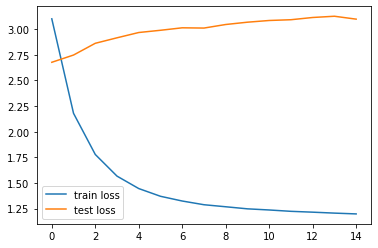

In [ ]:
# plot losses
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="test loss")
plt.legend()
plt.show()

In [ ]:
# plot accuracy
plt.plot(history.history['accuracy'], label="train accuracy")
plt.plot(history.history['val_accuracy'], label="test accuracy")
plt.legend()
plt.show()